<a href="https://colab.research.google.com/github/Su-Ng/KNN/blob/master/learning_from_history.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook demonstrates:

How to download a dataset from data.gov.sg
How to formulate the dataset into a Machine Learning problem for Forecasting and train a simple Neural Network to predict the next value.
How to formulate the same dataset into an ML problem for Pattern Recognition and train a different Neural Network to predict the pattern.

In [ ]:
# dataset downloading
import io
import requests
import zipfile

# data processing
import pandas as pd

# visualisation
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# models
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [ ]:
# https://data.gov.sg/dataset/gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly
DATASET_URL = 'https://data.gov.sg/dataset/92bcfcdf-cbb2-4497-a855-5aad9cf95cad/download'

headers = {
    'User-Agent': 'Mozilla/5.0',
}
response = requests.get(DATASET_URL, headers=headers)
z = zipfile.ZipFile(io.BytesIO(response.content))
z.extractall()

In [ ]:
# get the filename
z.printdir()

File Name                                             Modified             Size
metadata-gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.txt 2020-06-27 05:19:06         2520
gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv 2020-06-27 05:19:06         7647


In [ ]:
# Note: update CSV_FILE to the .csv filename from above
CSV_FILE = 'gross-domestic-product-in-chained-2015-dollars-year-on-year-growth-rate-quarterly.csv'

df = pd.read_csv(CSV_FILE, parse_dates=True, index_col=0)
df.head()

,level_1,value
quarter,,
1976-01-01,GDP In Chained (2015) Dollars,8.2
1976-04-01,GDP In Chained (2015) Dollars,7.4
1976-07-01,GDP In Chained (2015) Dollars,7.2
1976-10-01,GDP In Chained (2015) Dollars,7.0
1977-01-01,GDP In Chained (2015) Dollars,6.2


# **Data Exploration**


1.   Plot the dataset
2.   Compute the min, max, etc
3.   Plot the autocorrelation









Compute the min, max, etc
Plot the autocorrelation

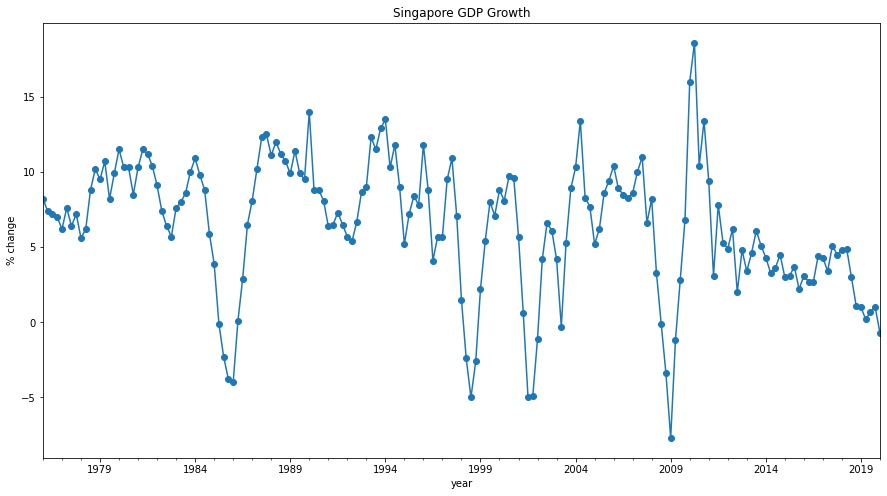

In [ ]:
df['value'].plot(figsize=(15, 8), marker='o', title='Singapore GDP Growth')
plt.xlabel('year')
plt.ylabel('% change')
plt.show()

In [ ]:
df['value'].describe()

count    177.000000
mean       6.450282
std        4.367833
min       -7.700000
25%        4.200000
50%        7.100000
75%        9.500000
max       18.600000
Name: value, dtype: float64

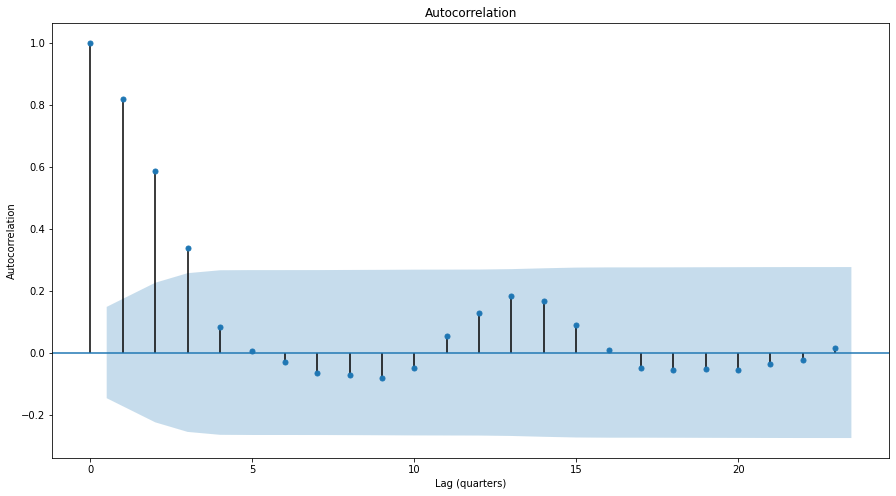

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_acf(df['value'], ax=ax)
ax.set_ylabel('Autocorrelation')
ax.set_xlabel('Lag (quarters)')
plt.show()

In [ ]:
window_size = 3 # largest number of lags above the 95% confidence band

# **Windowing**



1.   Create shifted windows of the dataset.
2.   Use this to setup our inputs and target




In [ ]:
# original dataset
df['value']

quarter
1976-01-01    8.2
1976-04-01    7.4
1976-07-01    7.2
1976-10-01    7.0
1977-01-01    6.2
             ... 
2019-01-01    1.0
2019-04-01    0.2
2019-07-01    0.7
2019-10-01    1.0
2020-01-01   -0.7
Name: value, Length: 177, dtype: float64

In [ ]:
# shift up 1 step in time using -1
# (note the quarter index does not change, we'll fix that later)
df['value'].shift(-1)

quarter
1976-01-01    7.4
1976-04-01    7.2
1976-07-01    7.0
1976-10-01    6.2
1977-01-01    7.6
             ... 
2019-01-01    0.2
2019-04-01    0.7
2019-07-01    1.0
2019-10-01   -0.7
2020-01-01    NaN
Name: value, Length: 177, dtype: float64

In [ ]:
# shift up in time using -2
# (note the quarter index does not change, we'll fix that later)
df['value'].shift(-2)

quarter
1976-01-01    7.2
1976-04-01    7.0
1976-07-01    6.2
1976-10-01    7.6
1977-01-01    6.4
             ... 
2019-01-01    0.7
2019-04-01    1.0
2019-07-01   -0.7
2019-10-01    NaN
2020-01-01    NaN
Name: value, Length: 177, dtype: float64

In [ ]:
# column-wise concatenation

# List comprehension, equivalent to:
# new_columns = []
# for i in range(window_size):
#    new_columns.append(df['value'].shift(-i))
new_columns = [df['value'].shift(-i) for i in range(window_size+1)]
new_column_names = [f't+{i}' for i in range(window_size+1)]

df_windowed = pd.concat(new_columns, axis=1)
df_windowed.columns = new_column_names
df_windowed

,t+0,t+1,t+2,t+3
quarter,,,,
1976-01-01,8.2,7.4,7.2,7.0
1976-04-01,7.4,7.2,7.0,6.2
1976-07-01,7.2,7.0,6.2,7.6
1976-10-01,7.0,6.2,7.6,6.4
1977-01-01,6.2,7.6,6.4,7.2
...,...,...,...,...
2019-01-01,1.0,0.2,0.7,1.0
2019-04-01,0.2,0.7,1.0,-0.7
2019-07-01,0.7,1.0,-0.7,NaN


In [ ]:
# cleanup the NaN at the bottom of the dataset
df_windowed.dropna(inplace=True)
df_windowed

,t+0,t+1,t+2,t+3
quarter,,,,
1976-01-01,8.2,7.4,7.2,7.0
1976-04-01,7.4,7.2,7.0,6.2
1976-07-01,7.2,7.0,6.2,7.6
1976-10-01,7.0,6.2,7.6,6.4
1977-01-01,6.2,7.6,6.4,7.2
...,...,...,...,...
2018-04-01,4.9,3.0,1.1,1.0
2018-07-01,3.0,1.1,1.0,0.2
2018-10-01,1.1,1.0,0.2,0.7


In [ ]:
# Formulate our problem

df_windowed.columns

Index(['t+0', 't+1', 't+2', 't+3'], dtype='object')

In [ ]:
# the target we want to predict (lowercase y is a convention for a vector)
y = df_windowed['t+3']

# the input data (uppercase X is a convention for a matrix)
X = df_windowed.drop(columns=['t+3'])

X.shape, y.shape

((174, 3), (174,))

# **Neural Network**
1.  Create a neural network using Tensorflow-Keras
2.  Split the dataset into training and test sets
3.  Train the neural network using the training set.
4.  Evaluate the neural network using the test set.

In [ ]:
# https://www.tensorflow.org/guide/keras/overview
# Create a simple Neural Network with 2 Dense Layers
from tensorflow.keras import layers

model = tf.keras.Sequential()
model.add(layers.Dense(16, input_shape=(3,), activation='relu'))
model.add(layers.Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                64        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((130, 3), (44, 3), (130,), (44,))

In [ ]:
# Note that the data is shuffled in time
# This is okay because we already preserved the history!
#
# If this bothers you, you can use train_test_split(X, y, shuffle=False)
# It does affect how the Neural Network is initialised, but since we
# will be go through the dataset multiple rounds, it doesn't really matter.
#
# It may matter if your dataset is huge, because the Neural Network training
# gets more chances see the older data. 
X_train

,t+0,t+1,t+2
quarter,,,
1999-07-01,8.0,7.1,8.8
1987-10-01,12.5,11.1,12.0
1987-04-01,10.2,12.3,12.5
2018-01-01,4.8,4.9,3.0
1993-07-01,11.5,12.9,13.5
...,...,...,...
2012-04-01,6.2,2.0,4.8
2004-01-01,10.3,13.4,8.3
2005-04-01,6.2,8.6,9.4


In [ ]:
# What matters is that each row of X_train and each row of y_train
# are for the same quarter!
y_train

quarter
1999-07-01     8.1
1987-10-01    11.2
1987-04-01    11.1
2018-01-01     1.1
1993-07-01    10.3
              ... 
2012-04-01     3.4
2004-01-01     7.7
2005-04-01    10.4
1986-04-01     8.1
2014-04-01     3.0
Name: t+3, Length: 130, dtype: float64

In [ ]:
# train!
# Note: if you have more data, you can split the dataset 3 ways:
#  train, validation, test
# And then use the validation set (e.g. X_val, y_val) in validation_data

model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, batch_size=16, epochs=50,
                    validation_data=(X_test, y_test))

Epoch 1/50
9/9 [==============================] - 0s 22ms/step - loss: 177.9045 - mae: 11.8963 - val_loss: 144.4692 - val_mae: 10.6782
Epoch 2/50
9/9 [==============================] - 0s 7ms/step - loss: 157.7847 - mae: 11.1866 - val_loss: 128.5039 - val_mae: 10.0500
Epoch 3/50
9/9 [==============================] - 0s 7ms/step - loss: 140.3627 - mae: 10.5400 - val_loss: 114.2395 - val_mae: 9.4532
Epoch 4/50
9/9 [==============================] - 0s 7ms/step - loss: 124.1424 - mae: 9.9021 - val_loss: 101.5944 - val_mae: 8.8909
Epoch 5/50
9/9 [==============================] - 0s 7ms/step - loss: 109.6064 - mae: 9.2976 - val_loss: 90.0088 - val_mae: 8.3415
Epoch 6/50
9/9 [==============================] - 0s 7ms/step - loss: 96.7372 - mae: 8.7130 - val_loss: 79.2792 - val_mae: 7.7943
Epoch 7/50
9/9 [==============================] - 0s 6ms/step - loss: 84.7345 - mae: 8.1380 - val_loss: 69.6058 - val_mae: 7.2621
Epoch 8/50
9/9 [==============================] - 0s 7ms/step - loss: 74.26

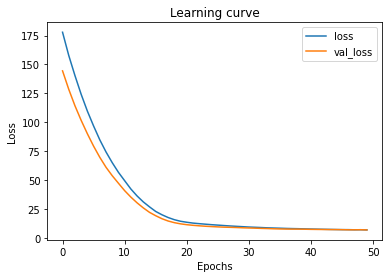

In [ ]:
# Check for overfitting, which is when val_loss starts to go up but
# loss stays decreases or stays constant.

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Learning curve')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

In [ ]:
model.save('model.h5')

In [ ]:
# Get a prediction from our model for our data and plot it against the truth

y_pred = model.predict(X)

df_pred = pd.DataFrame(index=X.index, data={'predictions': y_pred.ravel()})
df_pred

,predictions
quarter,
1976-01-01,6.781579
1976-04-01,6.668001
1976-07-01,6.051785
1976-10-01,6.851614
1977-01-01,6.434645
...,...
2018-04-01,0.890202
2018-07-01,0.587487
2018-10-01,0.500615


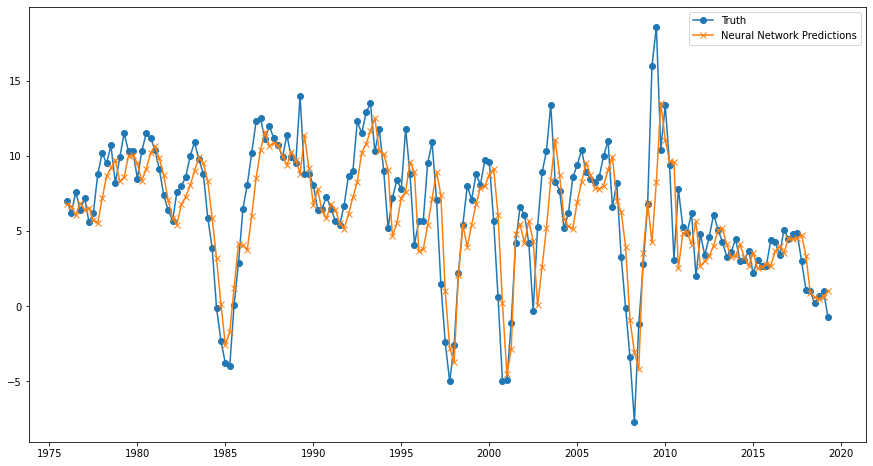

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(y, label='Truth', marker='o')
ax.plot(df_pred, label='Neural Network Predictions', marker='x')
ax.legend()
plt.show()